# Итоговый проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

**План проекта**

1. Постановка задачи
2. Загрузка данных
3. EDA
4. Обработка пропусков
5. Обработка выбросов
6. Генерация новых признаков
7. Отбор признаков
8. Разбиение на train и test
7. Построение модели
8. Прогнозирование на тестовом датасете

# 1. Постановка задачи

* Материалы к проекту (файлы):
train.csv
test.csv

* Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

* Целевая переменная:
Price

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 12})

**С помощью функции выводим R2 - коэффициент детерминации для train и test, потом отображаем на графике**

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [3]:
def my_hist(x, figsize=(14, 3)):
    # Гисторграмма + медиана/мода/средн.арифм.
    target_mean = round(x.mean(), 2)
    target_median = x.median()
    target_mode = x.mode()[0]

    plt.figure(figsize=figsize)

    sns.distplot(x, bins=min(50,len(set(x.unique()))))
    
    plt.axvline(x=[target_mean], label='mean',
                linestyle=':', color="red", linewidth=4)
    plt.axvline(x=[target_median], label='median',
                linestyle='--', color="green", linewidth=4)
    plt.axvline(x=[target_mode], label='mode',
                linestyle='-.', color="brown", linewidth=4)

    plt.title(f'Distribution of {x.name}')
    plt.xlabel(x.name)
    plt.ylabel('Frequency')
    plt.show()

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# 2. Загрузка данных

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В тренировочном датасете 10000 строк и 20 столбцов.
По предоставленным данным видим, что признаки LifeSquare и Healthcare_1 имеют пропуски, необходимо будет эти пропуски обработать.
Так же имеются строковые признаки: Ecology_2, Ecology_3, Shops_2.
Кроме того, DistrictId и Id нужно отнести к категориальным признакам.

In [7]:
test_df=pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
print('Строк в train:', train_df.shape[0])
print('Строк в test:', test_df.shape[0])

Строк в train: 10000
Строк в test: 5000


**Приведение типов**

In [9]:
train_df.DistrictId=train_df.DistrictId.astype('object')
train_df.Id=train_df.Id.astype('object')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# 3. EDA

**Обзор данных – целевая переменная**

Сначала смотрим на нашу целевую переменную Price.

In [10]:
train_df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

Создадим гистограмму, чтобы окончательно убедиться в том, с каким распределением мы имеем дело.

<AxesSubplot:xlabel='Price', ylabel='Density'>

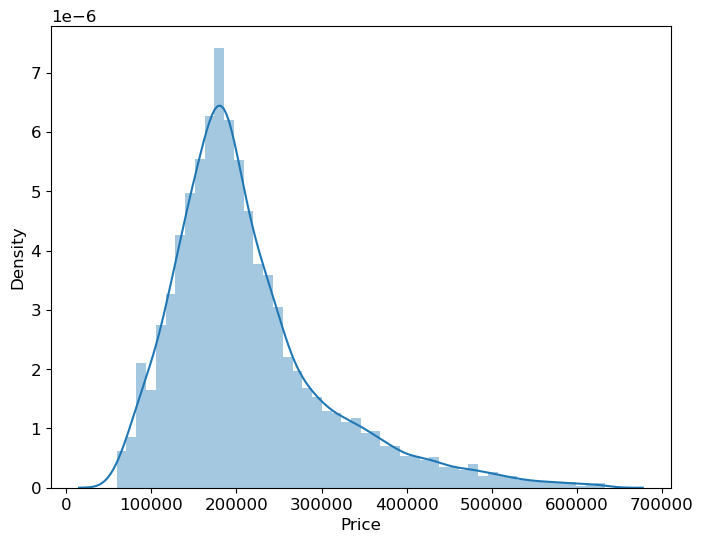

In [11]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train_df['Price'])

По гистограмме видно, что с правой стороны тянется длинный хвост, это указывает на то, что имеются дома с высокой стоймостью, мы их трогать не будем, т.к. это могут быть элитные объекты недвижимости

**Количественные признаки**

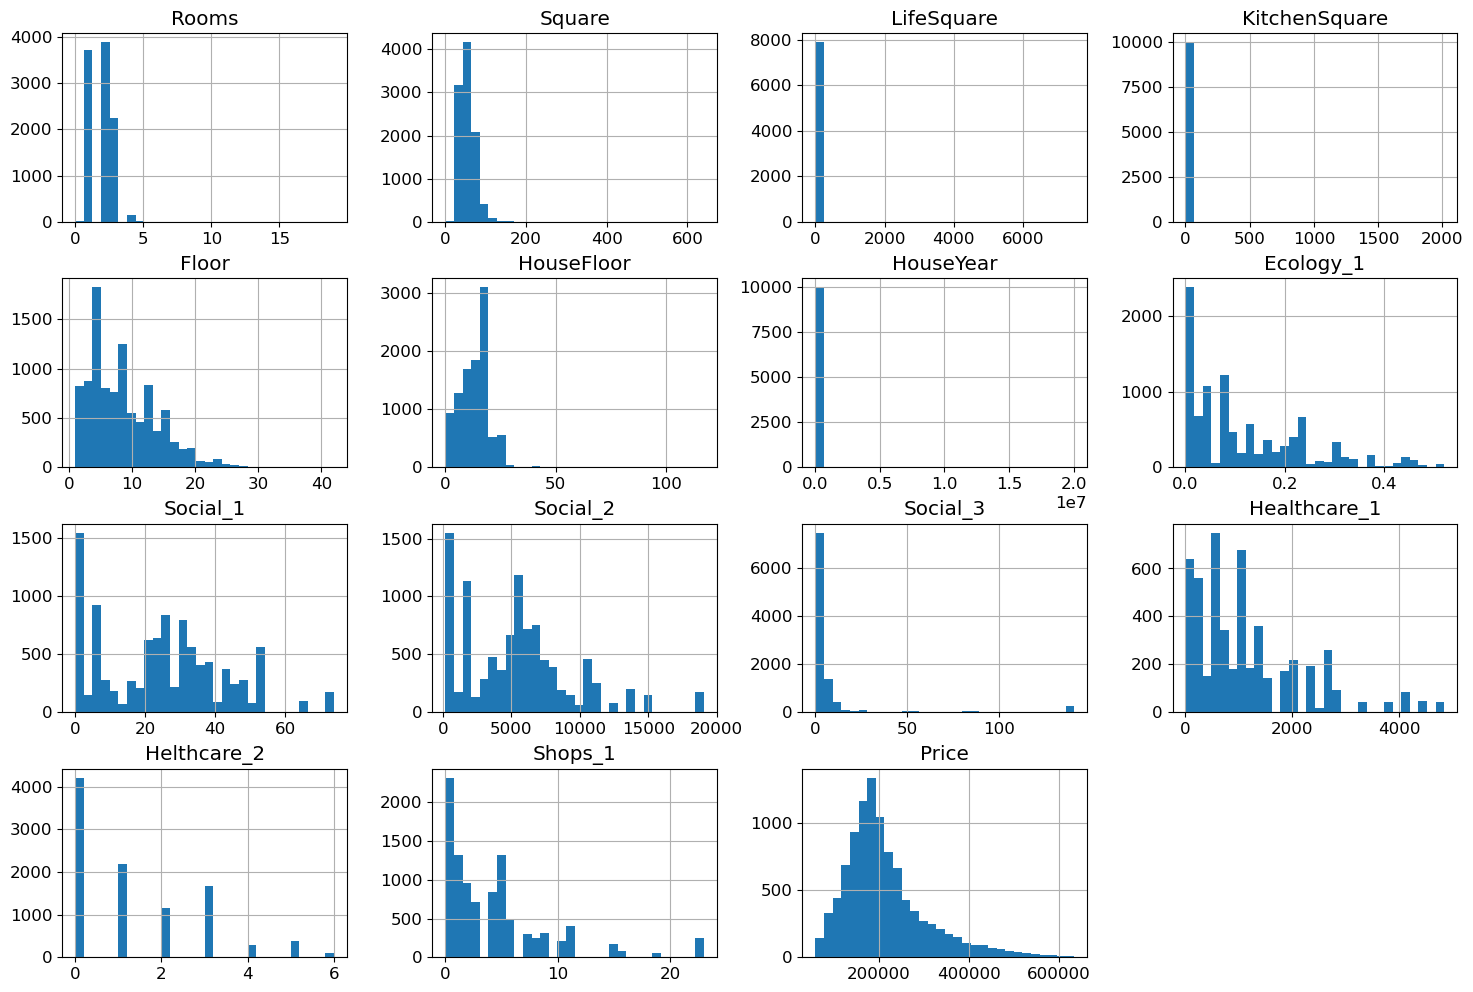

In [12]:
train_df.select_dtypes(exclude=['object'])
train_df.hist(figsize=(18,12), bins=30)
plt.show()

На гистограммах явно видно наличие выбросов в количестве комнат, площадях, в количестве этажей и годах постройки дома.
Helthcare_2 - скорее относится к категориальным признакам.
Показатели местности Social, и Shops интерпретировать трудно.

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Описание датасета подтверждает наши заключения по показателям признаков.

**Категориальные признаки**

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Посмотрим из чего стостоят признаки

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

Здесь показано сколько объектов по каждой из строк, позже необходимо будет поменять эти признаки на бинарные

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# 4. Обработка пропусков

In [19]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Видим, что большое количество пропусков по двум признакам LifeSquare и Healthcare_1

**LifeSquare**

In [20]:
train_df[['Square', 'KitchenSquare', 'LifeSquare']].head(10)

,Square,KitchenSquare,LifeSquare
0,47.981561,6.0,29.442751
1,65.683640,8.0,40.049543
2,44.947953,0.0,29.197612
3,53.352981,9.0,52.731512
4,39.649192,7.0,23.776169
5,80.384479,12.0,46.683720
6,62.254114,7.0,37.160377
7,80.312926,0.0,NaN
8,64.511437,1.0,NaN
9,46.461409,8.0,18.915552


В жилой площади имеются 2113 пропусков, высчитаем ее с помощью разницы между общей площадью объекта и площадью кухни.

In [21]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna()) 
         
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare']

**Healthcare_1**

Данный признак имеет слишком большой процент пропусков - 48%, удалим этот признак.

In [22]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

# 5. Обработка выбросов

Ещё раз посмотрим на признаки в которых явно присутствуют выбросы.

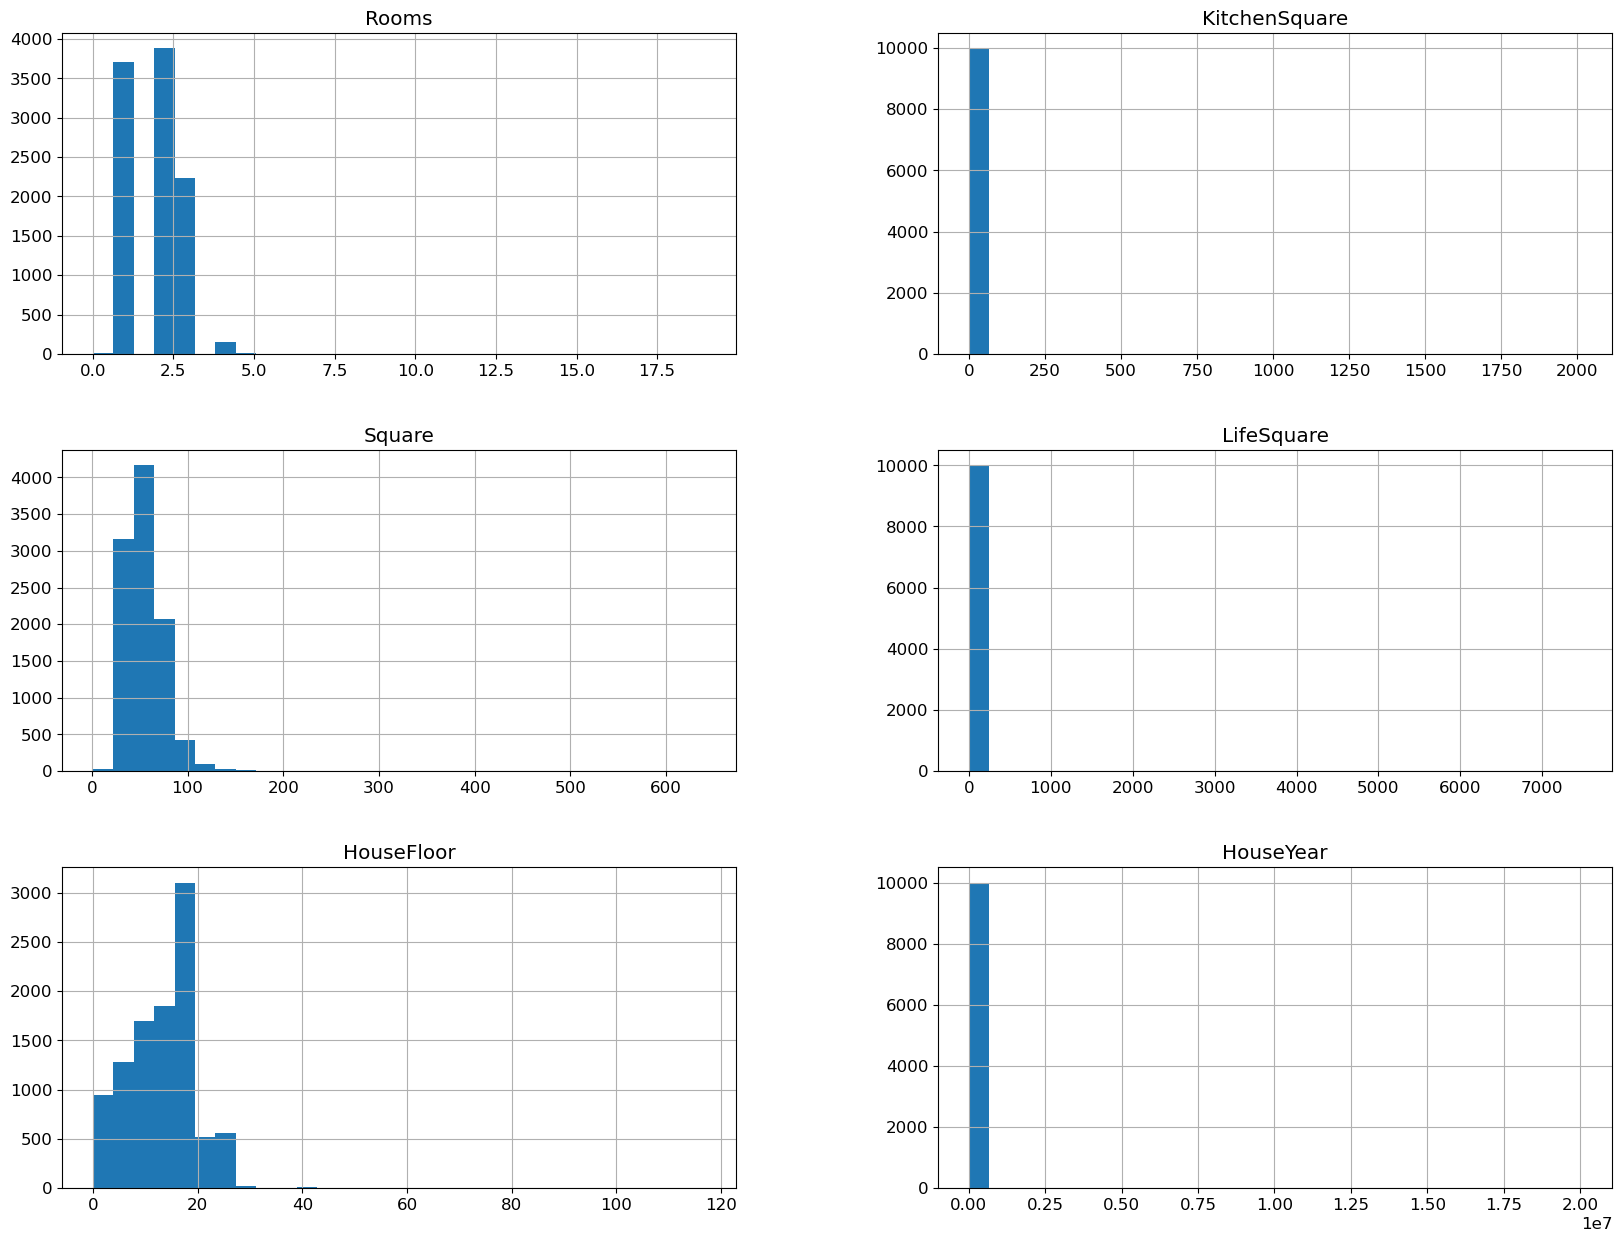

In [23]:
train_df[['Rooms','KitchenSquare', 'Square', 'LifeSquare',  'HouseFloor','HouseYear']].hist(bins=30, figsize=(20,15))
plt.show()

**Rooms**

In [24]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

По выборке мы видим, что чаще встречаются объекты с 2-мя комнатами.
0 - это выбросы, 10, 19 и 6 - тоже отнесем к выбросам. т.е. всего 4 значения (12 объектов) заменим на медиану.

In [25]:
train_df.loc[(train_df['Rooms'] < 1) | (train_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].median()

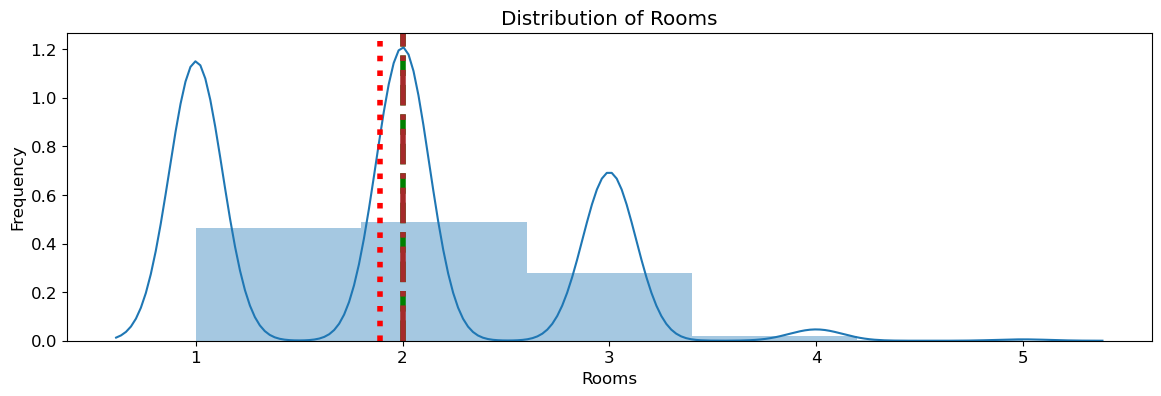

In [26]:
# На гистограмме видно, что лишних значений нет
my_hist(train_df.Rooms,figsize=(14, 4))

**KitchenSquare**

In [27]:
train_df['KitchenSquare'].sort_values()

8227       0.0
3302       0.0
9098       0.0
760        0.0
8192       0.0
         ...  
2969     112.0
4651     112.0
9895     123.0
8584    1970.0
1064    2014.0
Name: KitchenSquare, Length: 10000, dtype: float64

In [28]:
condition = (train_df['KitchenSquare'].isna()) \
            | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
    
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [29]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**Square**

In [30]:
train_df['Square'].sort_values()

6392      1.136859
8283      1.988943
4853      2.377248
1608      2.596351
9294      2.954309
           ...    
1981    212.932361
1982    275.645284
4690    409.425181
4262    604.705972
6977    641.065193
Name: Square, Length: 10000, dtype: float64

In [31]:
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 250), 'Square'] = train_df['Square'].median()

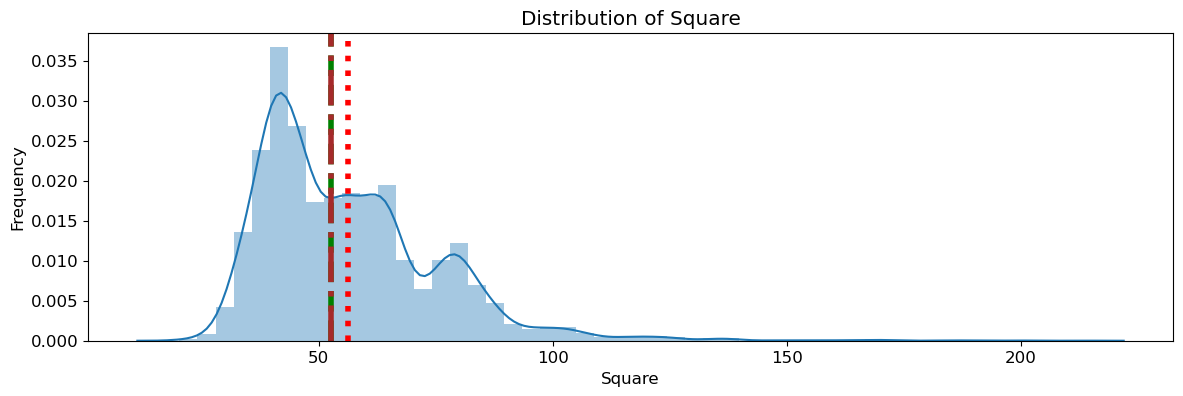

In [32]:
my_hist(train_df.Square,figsize=(14, 4))

**LifeSquare**

In [33]:
train_df['LifeSquare'].sort_values()

6609       0.370619
26         0.641822
9602       0.795539
4853       0.873147
2887       1.049867
           ...     
4690     410.639749
8437     461.463614
4262     603.705972
6977     638.163193
4328    7480.592129
Name: LifeSquare, Length: 10000, dtype: float64

In [34]:
train_df.loc[(train_df['LifeSquare'] < 15) | (train_df['LifeSquare'] > 200), 'LifeSquare'] = train_df['Square']

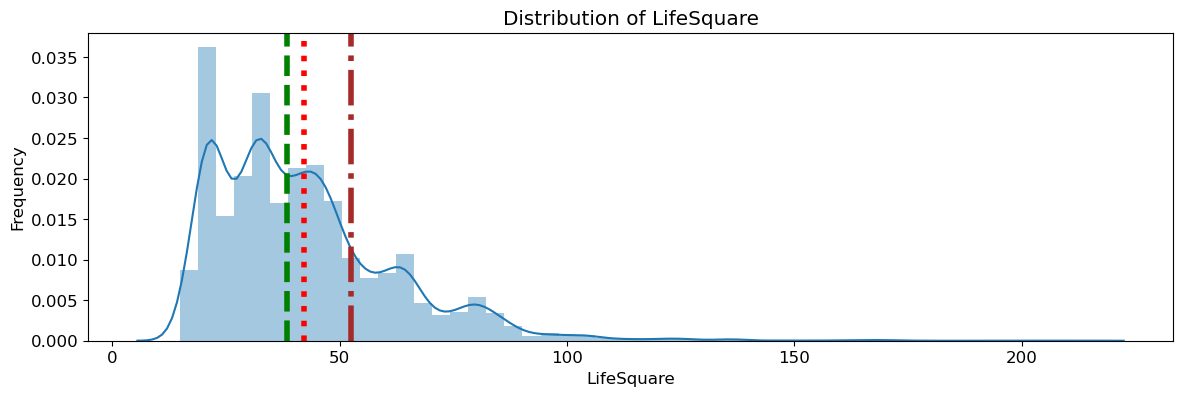

In [35]:
my_hist(train_df.LifeSquare,figsize=(14, 4))

**HouseFloor, Floor** 

In [36]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [37]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

По выборке видно, что в HouseFloor присутствует 0 - это выбросы. И все значения свыше 42, тоже быдем считать выбросами в соответствии с этажностью домов, заменим их на медиану.

In [38]:
train_df.loc[(train_df['HouseFloor'] < 1) | (train_df['HouseFloor'] > 40), 'HouseFloor'] = train_df['HouseFloor'].median()

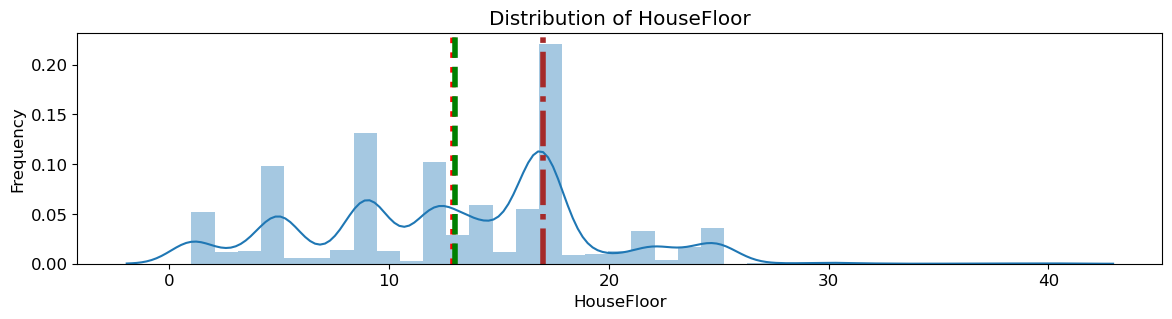

In [39]:
my_hist(train_df.HouseFloor)

In [40]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40.])

In [41]:
(train_df['HouseFloor'] < train_df['Floor']).sum()

1614

Данное количество объектов указывает на превышение этажа над этажностью дома, необходимо заменить эти данные на рандомное значения, создадим для этого новый признак

In [42]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_out

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1614)

In [43]:
train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [44]:
(train_df['HouseFloor'] < train_df['Floor']).sum()

0

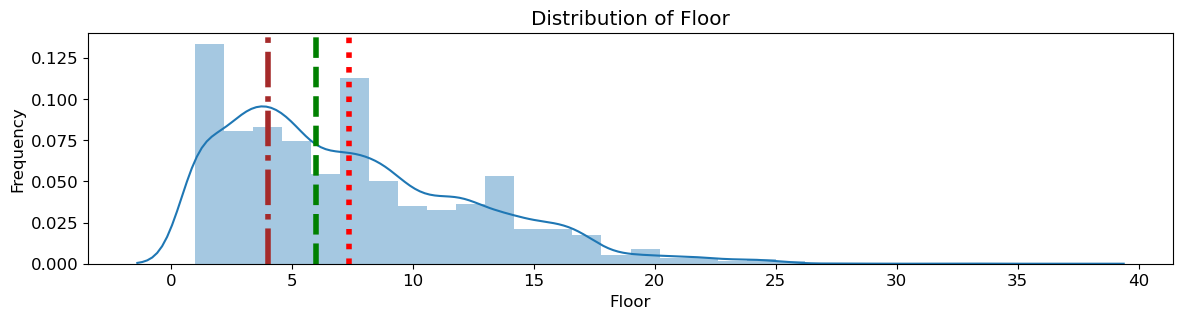

In [45]:
my_hist(train_df.Floor)

**HouseYear**

In [46]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

В данном признаке следует обратить внимание на последние две даты, здесь явно опечатка, исправим их на более подходящие значения. Выведим строки этих дат.

In [47]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

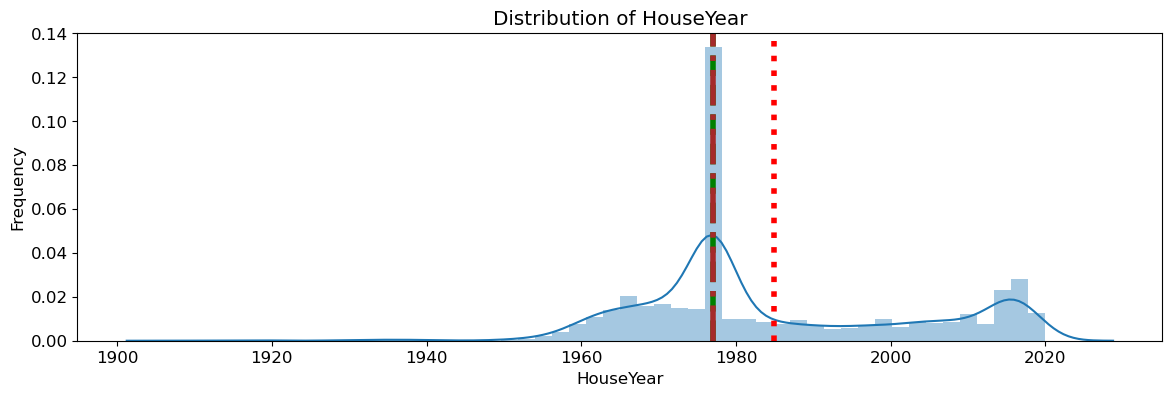

In [48]:
my_hist(train_df.HouseYear,figsize=(14, 4))

**Создадим класс DataGenerator, в котором реализуем функции относительно подготовки данных для модели**

In [49]:
class DataGenerator():
# подготовка исходных данных

    def __init__(self):
    #параметры класса
    
        self.medians= None
        self.kitchensquare_quantile=None
        
    def fit(self, X):
    # сохранение статистик
        self.medians = X.median()
        self.kitchensquare_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
    # трансформация данных
    
    # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) \
             & (~X['Square'].isna()) \
             & (~X['KitchenSquare'].isna()) 
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
    
    # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
    
    # Rooms
        X.loc[(X['Rooms'] < 1) | (X['Rooms'] > 5), 'Rooms'] = self.medians['Rooms']
        
    # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                        | (X['KitchenSquare'] > self.kitchensquare_quantile)
    
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    
    # Square
        X.loc[(X['Square'] < 20) | (X['Square'] > 250), 'Square'] = self.medians['Square']
    
    # LifeSquare
        X.loc[(X['LifeSquare'] < 15) | (X['LifeSquare'] > 200), 'LifeSquare'] = X['Square']
    
    # HouseFloor, Floor
        X.loc[(X['HouseFloor'] < 1) | (X['HouseFloor'] > 42), 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_out = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_out, 'Floor'] = X.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))
                 
        X.fillna(self.medians, inplace=True)  
        
     # HouseYear 
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
            
        return X
            

# 6. Генерация новых признаков

**Dummies**

Данные три признака поделены на две категории А и В, прослеживается дисбаланс в значениях, в рамках обработки данных перекодируем их в 0 и 1.

In [50]:
bin_to_num = {'A':0, 'B':1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(bin_to_num)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(bin_to_num)
train_df['Shops_2'] = train_df['Shops_2'].replace(bin_to_num)

**DistrictId**

In [51]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [52]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,0,11,1,184966.930730,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,1,16,1,300009.450063,0,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,34,7759,0,1,3,1,220925.908524,0,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,0,5,1,175616.227217,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2,4,1,150226.531644,0,97


In [53]:
(train_df['DistrictId'] > 100).value_counts()

False    8577
True     1423
Name: DistrictId, dtype: int64

In [54]:
train_df['IsDistrictLarge'] = (train_df['DistrictId'] > 100).astype(int)

**MedPriceDis**

In [55]:
med_price_by_dis = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                .rename(columns={'Price':'MedPriceByDis'})
med_price_by_dis.head()              

,DistrictId,Rooms,MedPriceByDis
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [56]:
train_df = train_df.merge(med_price_by_dis, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDis
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.930730,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.450063,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.908524,0,174,0,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.227217,0,179,0,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531644,0,97,0,158539.052715


In [57]:
class FeatureGenerator():
    # генерация признаков
    
    def __init__(self):
    #параметры класса
    
        self.bin_to_num = None
        self.DistrictId_count = None
        self.med_price_by_dis = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Dummies
        self.bin_to_num = {'A':0, 'B':1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target
        
        df = X.copy()
        
        
        if y is not None:
            df['Price'] = y.values
             
            self.med_price_by_dis = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                .rename(columns={'Price':'MedPriceByDis'})
        
            self.med_price_by_dis_median = self.med_price_by_dis['MedPriceByDis'].median()
            
        
    def transform(self, X):
        
        # Dummies
        X['Ecology_2'] = X['Ecology_2'].map(self.bin_to_num)
        X['Ecology_3'] = X['Ecology_3'].map(self.bin_to_num)
        X['Shops_2'] = X['Shops_2'].map(self.bin_to_num)
        
        # DistrictID, IsDistrictLarge
        X = X.merge(district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictId'] > 100).astype(int)
        
        # Target 
        if self.med_price_by_dis is not None:
            X = X.merge(self.med_price_by_dis, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_dis_median, inplace=True)
            
        return X
            
        

**Выведим корреляцию признаков в датасете:**

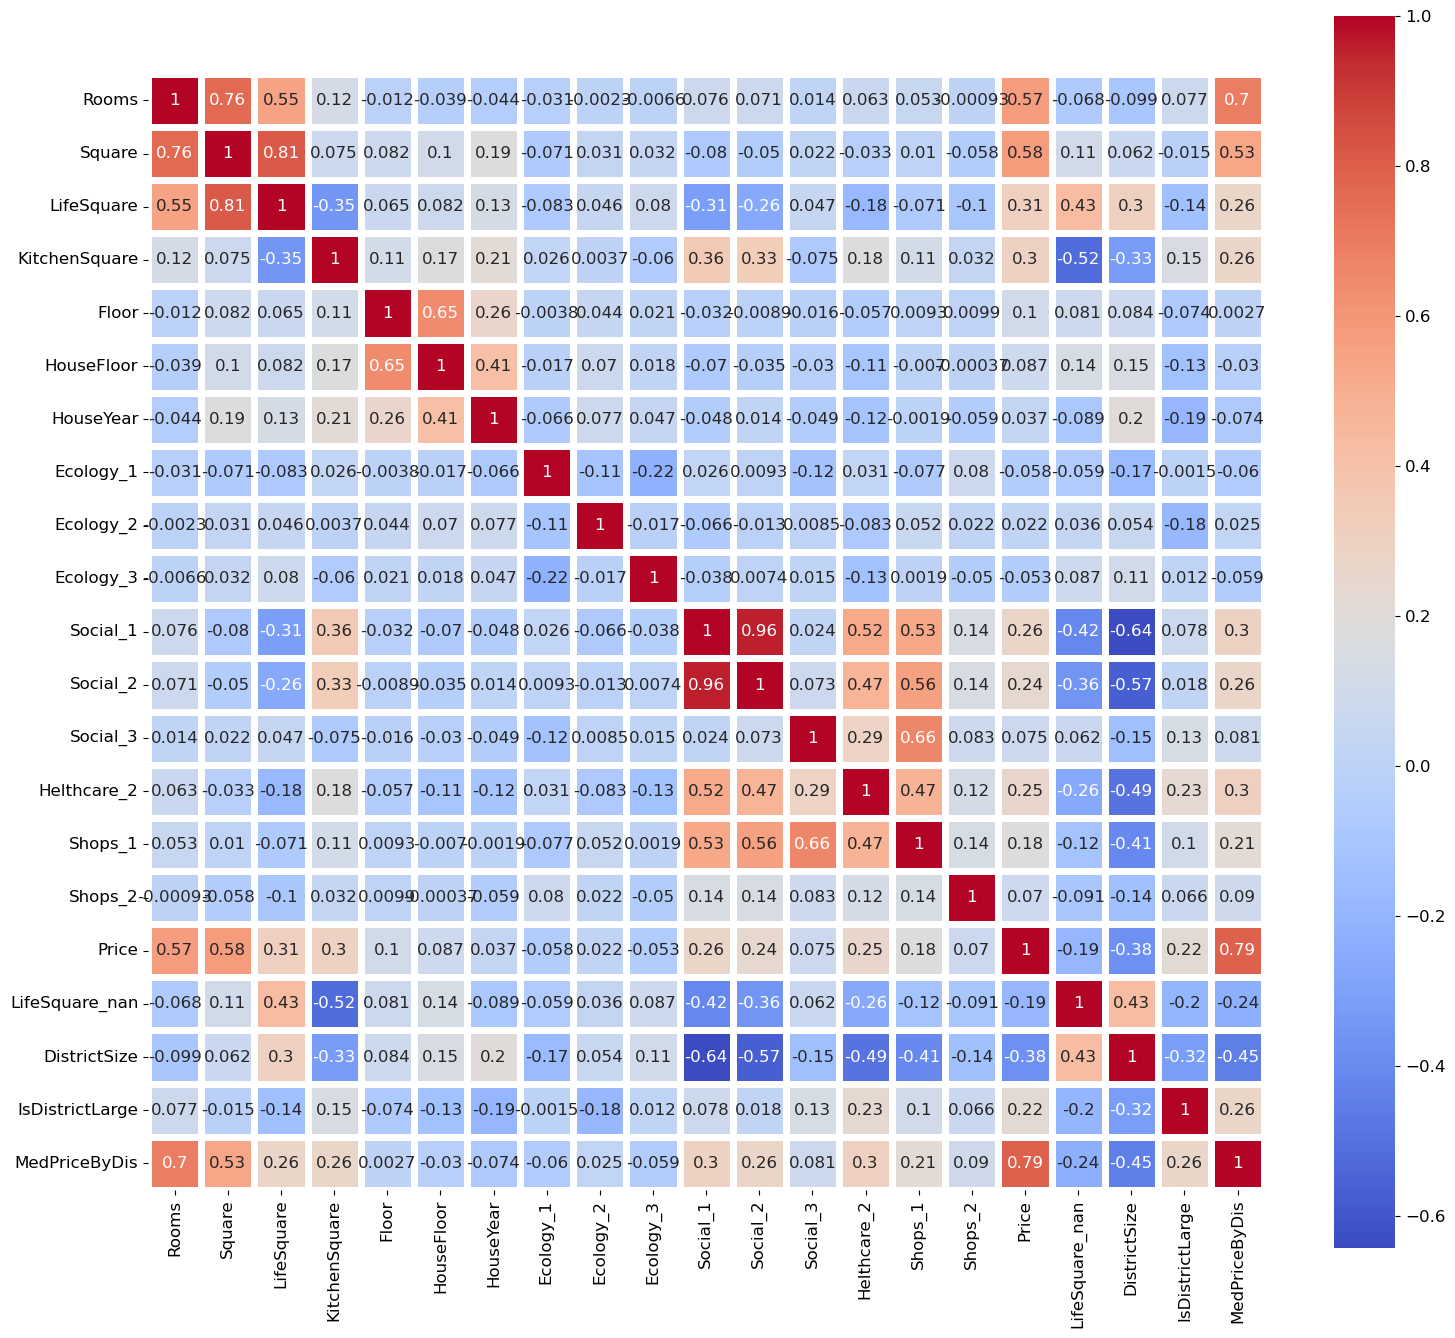

In [58]:
train_df_corr=train_df.corr()
plt.figure(figsize=(18,16))
sns.heatmap(train_df_corr, annot=True, linewidths=5, cmap='coolwarm', square=True)
plt.show()

### 7. Отбор признаков

In [59]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDis']

In [60]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2','Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

new_feature_names = ['LifeSquare_nan', 'DistrictSize', 'DistrictSize', 'MedPriceByDis', 'new_district']

target_name = 'Price'

# 8. Разбиение на train и test

In [61]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df=pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [63]:
generator = DataGenerator()
generator.fit(X_train)

X_train = generator.transform(X_train)
X_valid = generator.transform(X_valid)
test_df = generator.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape 

((6700, 19), (3300, 19), (5000, 19))

In [64]:
feat_generator = FeatureGenerator()
feat_generator.fit(X_train, y_train)

X_train = feat_generator.transform(X_train)
X_valid = feat_generator.transform(X_valid)
test_df = feat_generator.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [65]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [66]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(),test_df.isna().sum().sum()

(0, 0, 0)

# 9. Построение модели

In [67]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=20, min_samples_leaf=30,
                      random_state=42)

Train R2:	0.781
Test R2:	0.661


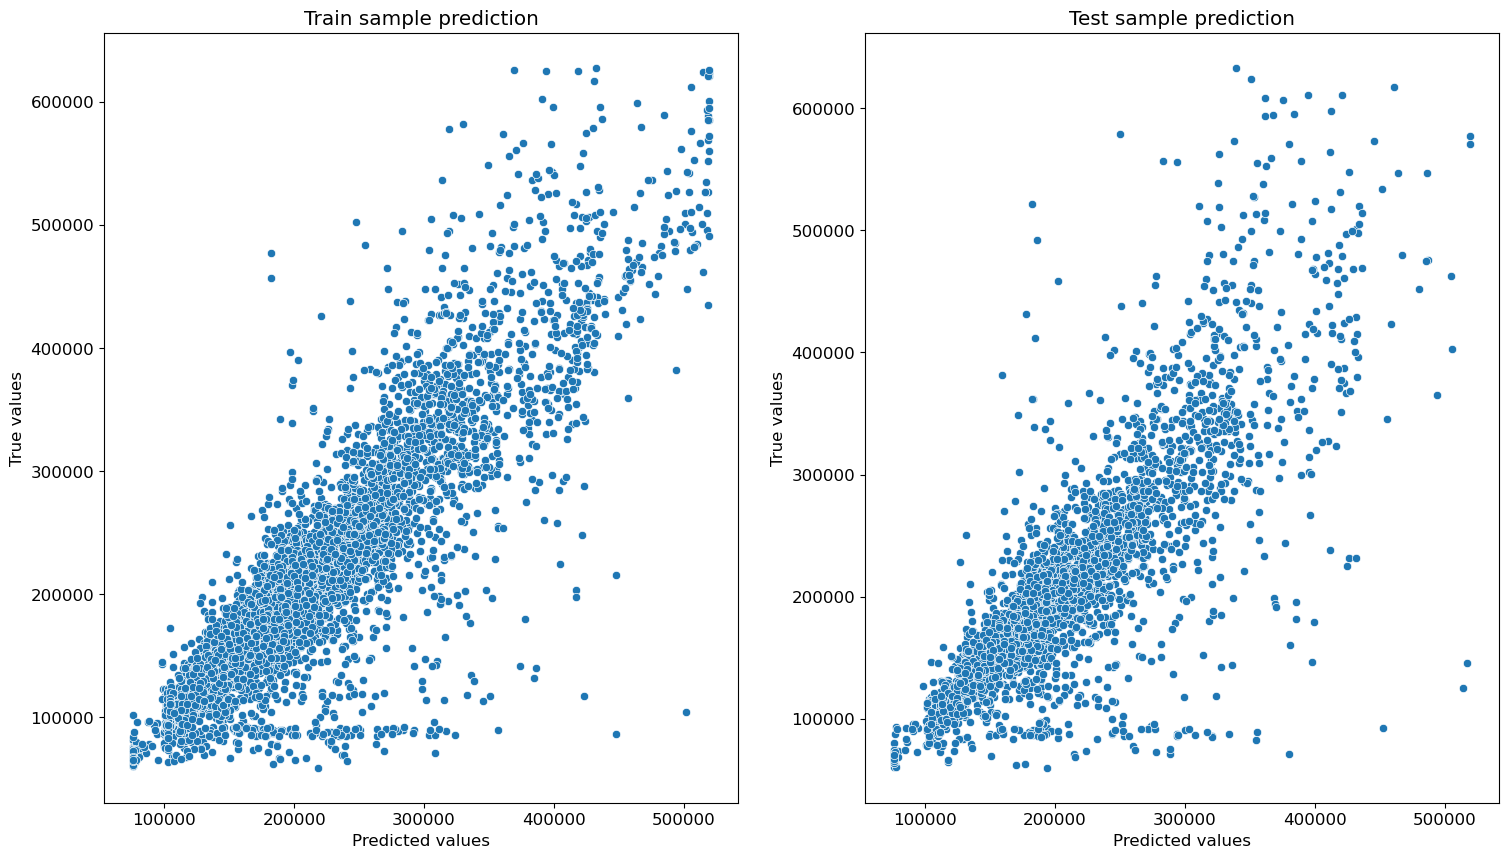

In [68]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [69]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)

cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=kf)
print('R2: {:.2f}'.format(cv_score.mean()))

R2: 0.72


**Важность признаков**

In [70]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False)


,feature,importance
24,MedPriceByDis,0.804801
1,Square,0.100033
12,Social_3,0.016073
2,LifeSquare,0.010209
22,DistrictSize,0.009227
3,KitchenSquare,0.009006
10,Social_1,0.008362
23,DistrictSize,0.007591
6,HouseYear,0.006465
5,HouseFloor,0.005520


# 10. Прогнозирование на тестовом датасете

In [71]:
predictions = rf_model.predict(test_df)

preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = predictions
preds.head()

,Id,Price
0,0,163441.648928
1,1,255447.605260
2,2,258326.577003
3,3,290258.399227
4,4,135850.500159


In [72]:
preds.to_csv('KBibisheva_predictions.csv', index=False)

In [73]:
preds.shape

(5000, 2)